p.227-251, 278-289

## 4-6. XGBoost (eXtra Gradient Boost)
GBM에 기반하고 있지만 느린 수행 시간 및 과적합 규제 부재 등의 문제를 해결한 알고리즘이다. 병렬 CPU 환경에서 병렬 학습이 가능해 빠르게 학습 완료 가능.

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

### 파이썬 래퍼 XGBoost 하이퍼 파라미터
GBM과 유사한 하이퍼 파라미터를 가지고 있으며 조기 중단, 과적합 규제 위한 하이퍼 파라미터가 추가됨.
- 주요 일반 파라미터
  - booster: gbtree 또는 gblinear 선택.
  - silent: 디폴트는 0, 출력 메시지를 나타내고 싶지 않을 경우 1로 설정
  - nthread: CPU 실행 스레드 개수 조정. 디폴트는 CPU의 전체 스레드를 다 사용.
- 주요 부스터 파라미터
  - eta [default=0.3, alias: learning_rate]: GBM의 학습률과 같은 파라미터. 0~1 사이 값을 지정해 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값.
  - num_boost_rounds: n_estimators
  - min_child_weight: 디폴트는 1, 클수록 분할 자제. 과적합 조절
  - gamma: 디폴트 0. 리프 노드를 추가적으로 나눌지 결정할 최소 손실 감소 값. 해당 값보다 큰 손실이 감소된 경우 리프 노드 분리. 클수록 과적합 감소 효과 있음
  - max_depth: 디폴트 6. max_depth. 0 지정하면 깊이 제한 없음. 높으면 과적합 가능성이 높아짐. 3~10 사이 값이 보통
  - sub_sample: 디폴트 1. subsample. 과적합 제어 위해 데이터 샘플링하는 비율 지정. 주로 0.5~1 사이 값 사용
  - colsample_bytree: 디폴트 1. max_features. 트리 생성에 필요한 피처를 임의로 샘플링하는 데 사용.
  - lambda: 디폴트 1. L2 Regularization 적용 값. 클수록 과적합 감소 효과
  - alpha: 디폴트 0. L1 Regularization 적용 값. 클수록 과적합 감소 효과
  - scale_pos_weight: 디폴트 1. 비대칭한 클래스로 구성된 데이터 세트의 균형 유지를 위한 파라미터
- 학습 태스크 파라미터
  - objective: 최솟값을 가져야할 손실 함수 정의.
  - binary:logistic: 이진 분류
  - multi:softmax: 다중 분류 적용. 레이블 클래스 개수인 num_class 지정
  - multi:softprob: 개별 레이블 클래스의 해당되는 예측 확률 반환
  - eval_metric: 검증에 사용되는 함수 정의. 회귀는 rmse, 분류는 error 주로 사용. rmse, mae, logloss, error, merror, mlogloss, auc


In [2]:
import xgboost
print(xgboost.__version__)

2.0.0


### 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측

In [3]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [4]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [5]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [6]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [7]:
params = {'max_depth':3, # 트리 최대 깊이 3
          'eta': 0.1, # 학습률
          'objective': 'binary:logistic', # 이진 로지스틱
          'eval_metric': 'logloss', # 오류 함수의 평가 성능 지표
          'early_stoppings': 100}
num_rounds = 400 # 부스팅 반복 횟수

In [8]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기합니다
wlist = [(dtrain,'train'),(dtest, 'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round = num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.58431	eval-logloss:0.56554
[1]	train-logloss:0.51885	eval-logloss:0.50669
[2]	train-logloss:0.46457	eval-logloss:0.45868
[3]	train-logloss:0.41713	eval-logloss:0.41822
[4]	train-logloss:0.37585	eval-logloss:0.38103
[5]	train-logloss:0.34075	eval-logloss:0.35137
[6]	train-logloss:0.31028	eval-logloss:0.32588
[7]	train-logloss:0.28283	eval-logloss:0.30127
[8]	train-logloss:0.25925	eval-logloss:0.28197
[9]	train-logloss:0.23822	eval-logloss:0.26265
[10]	train-logloss:0.21951	eval-logloss:0.24821
[11]	train-logloss:0.20251	eval-logloss:0.23231
[12]	train-logloss:0.18759	eval-logloss:0.22079
[13]	train-logloss:0.17386	eval-logloss:0.20795
[14]	train-logloss:0.16199	eval-logloss:0.19764
[15]	train-logloss:0.15109	eval-logloss:0.18950
[16]	train-logloss:0.14056	eval-logloss:0.18052
[17]	train-logloss:0.13137	eval-logloss:0.17246
[18]	train-logloss:0.12329	eval-logloss:0.16512
[19]	train-logloss:0.11565	eval-logloss:0.15828
[20]	train-logloss:0.10860	eval-logloss:0.15436
[2

In [9]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.904 0.004 0.908 0.267 0.992 1.    1.    0.999 0.994 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9951


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

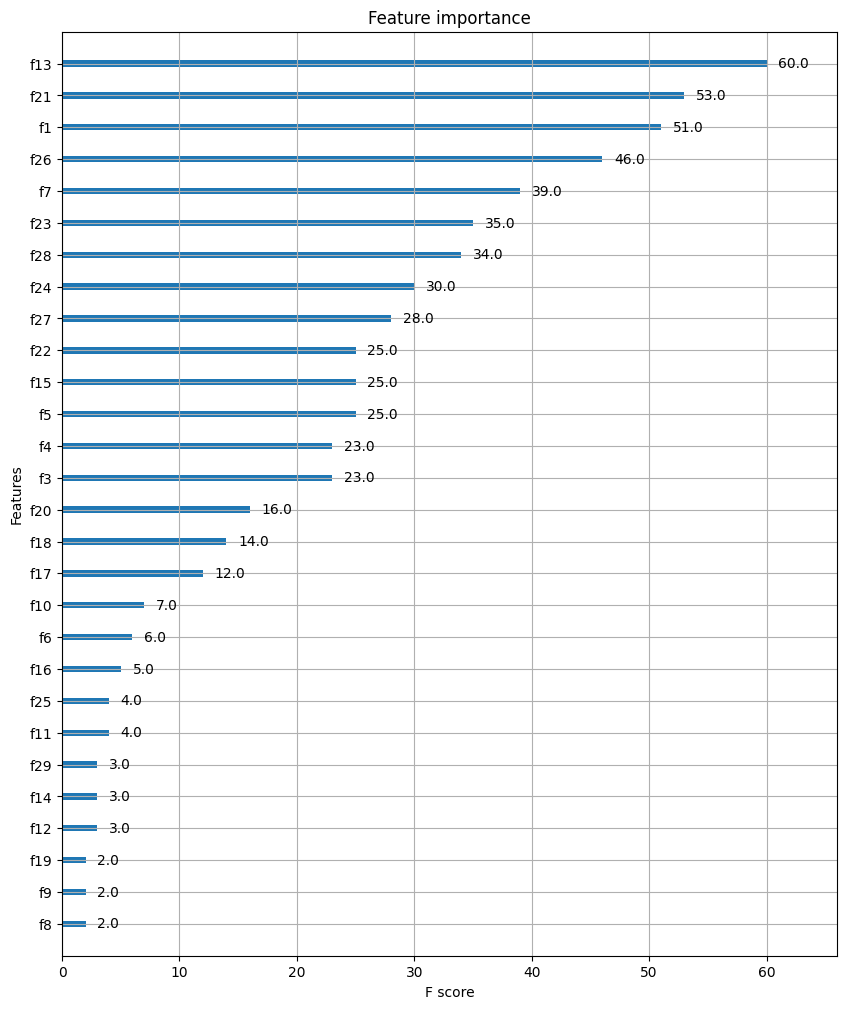

In [12]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

In [13]:
xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False,
           early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.584737,0.005961,0.592041,0.008024
1,0.517898,0.004745,0.532735,0.007335
2,0.462199,0.003589,0.483123,0.008418
3,0.415639,0.003043,0.441435,0.011510
4,0.375350,0.002036,0.406194,0.014400
5,0.340102,0.000854,0.373831,0.015171
6,0.308902,0.000900,0.348411,0.018183
7,0.281927,0.001335,0.324136,0.017817
8,0.257775,0.001182,0.304679,0.021239
9,0.236439,0.001313,0.286202,0.021203


### 사이킷런 래퍼 XGBoost의 개요 및 적용
- eta->learning rate
- sub_sample-> subsample
- lambda -> reg_lambda
- alpha -> reg_alpha

In [14]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [15]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9947


In [16]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals=[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.56554
[1]	validation_0-logloss:0.50669
[2]	validation_0-logloss:0.45868
[3]	validation_0-logloss:0.41822
[4]	validation_0-logloss:0.38103
[5]	validation_0-logloss:0.35137
[6]	validation_0-logloss:0.32588
[7]	validation_0-logloss:0.30127
[8]	validation_0-logloss:0.28197
[9]	validation_0-logloss:0.26265
[10]	validation_0-logloss:0.24821
[11]	validation_0-logloss:0.23231
[12]	validation_0-logloss:0.22079
[13]	validation_0-logloss:0.20795
[14]	validation_0-logloss:0.19764
[15]	validation_0-logloss:0.18950
[16]	validation_0-logloss:0.18052
[17]	validation_0-logloss:0.17246
[18]	validation_0-logloss:0.16512
[19]	validation_0-logloss:0.15828
[20]	validation_0-logloss:0.15436
[21]	validation_0-logloss:0.14633
[22]	validation_0-logloss:0.13936
[23]	validation_0-logloss:0.13393
[24]	validation_0-logloss:0.13015
[25]	validation_0-logloss:0.12489
[26]	validation_0-logloss:0.12206
[27]	validation_0-logloss:0.11890
[28]	validation_0-logloss:0.11637
[29]	validation_0-loglos

In [17]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9951


In [18]:
# early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.56554
[1]	validation_0-logloss:0.50669
[2]	validation_0-logloss:0.45868
[3]	validation_0-logloss:0.41822
[4]	validation_0-logloss:0.38103
[5]	validation_0-logloss:0.35137
[6]	validation_0-logloss:0.32588
[7]	validation_0-logloss:0.30127
[8]	validation_0-logloss:0.28197
[9]	validation_0-logloss:0.26265
[10]	validation_0-logloss:0.24821
[11]	validation_0-logloss:0.23231
[12]	validation_0-logloss:0.22079
[13]	validation_0-logloss:0.20795
[14]	validation_0-logloss:0.19764
[15]	validation_0-logloss:0.18950
[16]	validation_0-logloss:0.18052
[17]	validation_0-logloss:0.17246
[18]	validation_0-logloss:0.16512
[19]	validation_0-logloss:0.15828
[20]	validation_0-logloss:0.15436
[21]	validation_0-logloss:0.14633
[22]	validation_0-logloss:0.13936
[23]	validation_0-logloss:0.13393
[24]	validation_0-logloss:0.13015
[25]	validation_0-logloss:0.12489
[26]	validation_0-logloss:0.12206
[27]	validation_0-logloss:0.11890
[28]	validation_0-logloss:0.11637
[29]	validation_0-loglos

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

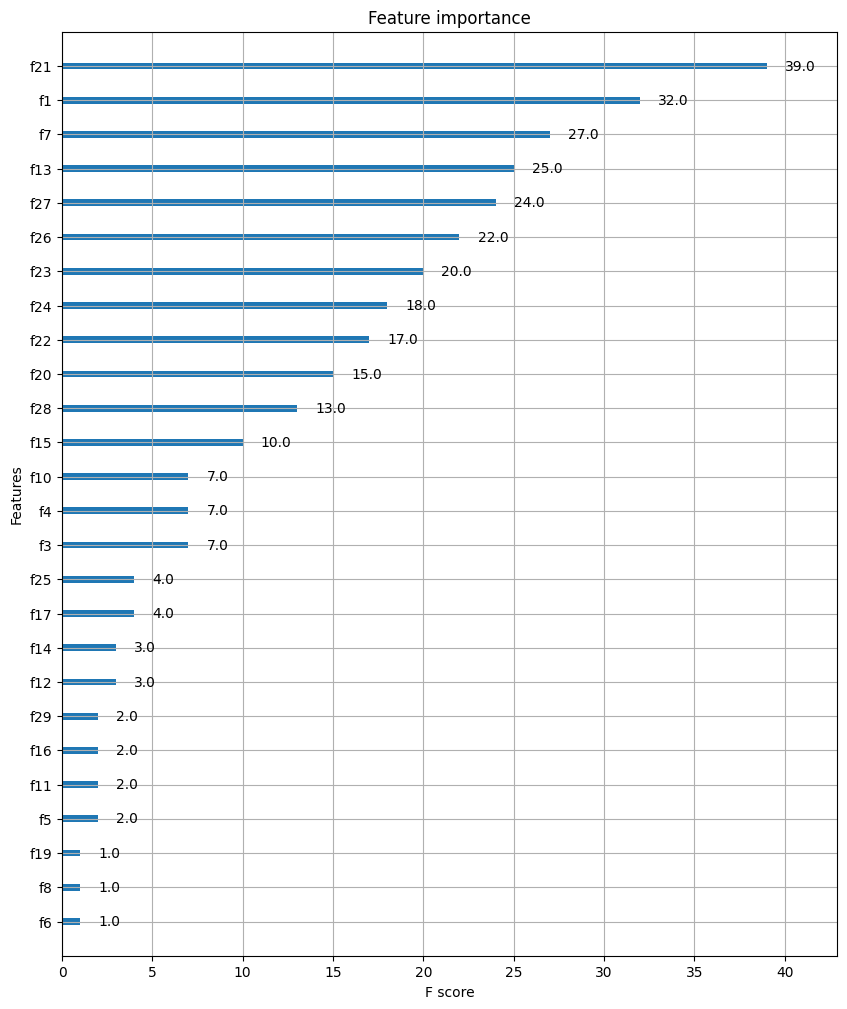

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

## 4-7. LightGBM

In [3]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, eval_metric="logloss", eval_set=evals)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 280, number of negative: 175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4542
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [5]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[32  5]
 [ 2 75]]
정확도: 0.9386, 정밀도: 0.9375, 재현율: 0.9740, F1: 0.9554, AUC: 0.9926


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

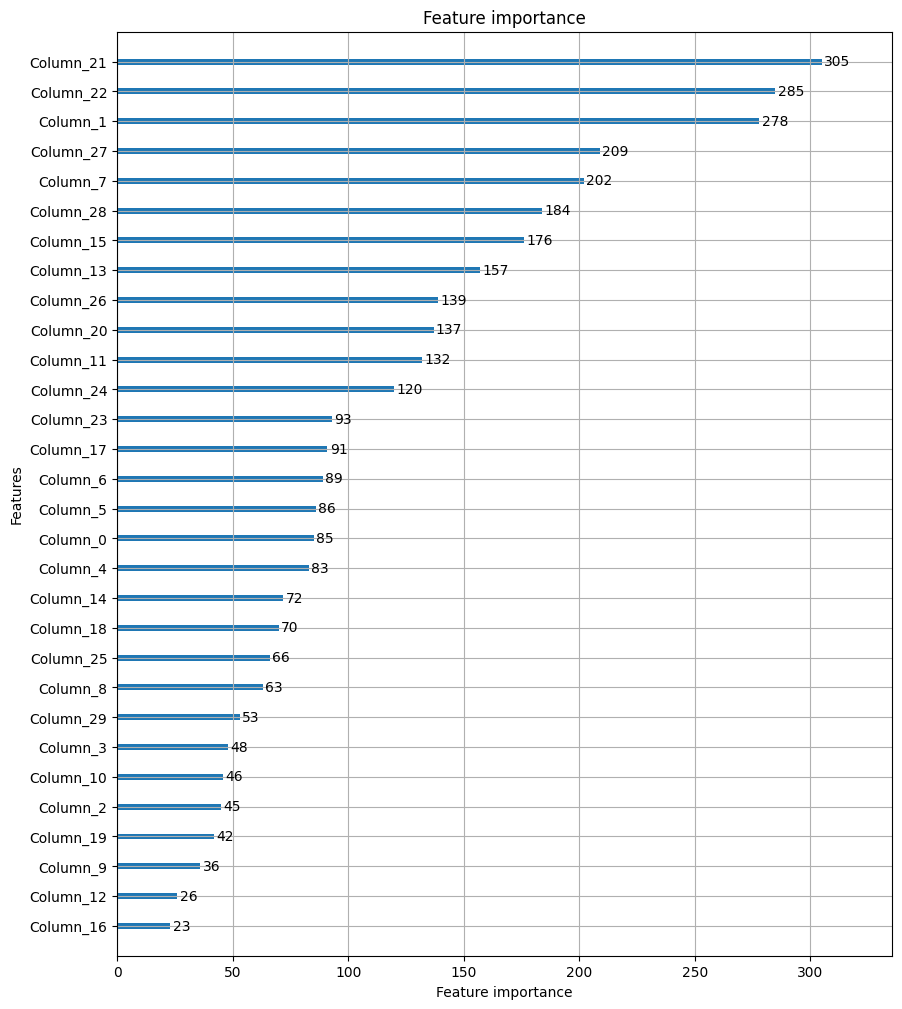

In [7]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

## 4-10. 스태킹 앙상블


In [8]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [9]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

In [10]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [12]:
from tables.registry import get_class_by_name
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [13]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [14]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [16]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

In [17]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [18]:
lr_final.fit(Stack_final_X_train,y_train)
stack_final=lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test,stack_final)))

최종 메타 모델의 예측 정확도: 0.9649
